## LDA

Using LDA to find hidden topics from the hotel reviews and the impact topic has on review score.


#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import warnings
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim import similarities
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

import spacy


import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt


import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud


ModuleNotFoundError: No module named 'pyLDAvis'

In [2]:
data = pd.read_csv('review_df1.csv')
len(data)

3520

## Pre-process data

In [3]:
# Convert the words to lowercase
data['N_Review_lower'] = data['Negative_Review'].str.lower()

# stop word list
stop_list = nltk.corpus.stopwords.words('english')
stop_list_extra = ['negative', 'positive', 'could', 'like', 'look', 'done', 'bit', 'everything', 'maybe', 'also',
                  'hotel', 'really', 'little', 'lot', 'would', 'go', 'even', 'nothing', 'especially','definitely',
                  'room', 'location', 'stay', 'very', 'extremely', 'beyond', 'extra', 'poor', 'nice',
                  'expect', 'however', 'made', 'great', 'thing']
stop_list.extend(stop_list_extra)

# Process
data['N_Review_tokenize'] = data['N_Review_lower'].apply(lambda x: nltk.word_tokenize(x))
data['N_Review_word'] = data['N_Review_tokenize'].apply(lambda x: [w for w in x if re.search('^[a-z]+$', w)])
data['N_Review_nostop'] = data['N_Review_word'].apply(lambda x: [w for w in x if w not in stop_list])
data['N_Review_lemmatize'] = data['N_Review_nostop'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
data['N_Review_stem'] = data['N_Review_lemmatize'].apply(lambda x: [stemmer.stem(w) for w in x])
data['N_Review_clean'] = data['N_Review_stem'].apply(lambda x: [w for w in x if len(w)>3])

data['N_Review_clean'].head()

0                             [shut, kept, turn, back]
1    [wait, readi, arriv, expect, freshen, wait, ne...
2                                [aircon, temperament]
3    [bedroom, better, tear, fabric, need, updat, o...
4    [start, finish, noisi, book, right, rude, staf...
Name: N_Review_clean, dtype: object

In [4]:
n_reviews = data['N_Review_clean']
n_reviews.head()

0                             [shut, kept, turn, back]
1    [wait, readi, arriv, expect, freshen, wait, ne...
2                                [aircon, temperament]
3    [bedroom, better, tear, fabric, need, updat, o...
4    [start, finish, noisi, book, right, rude, staf...
Name: N_Review_clean, dtype: object

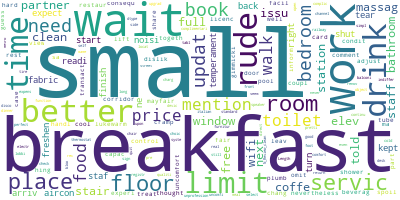

In [6]:
# Join the different processed titles together.
long_string = str(n_reviews)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

### Using wordcloud can help us identify more words to add to the stop list

In [7]:
n_dictionary = corpora.Dictionary(n_reviews)
print(n_dictionary)

Dictionary(3537 unique tokens: ['back', 'kept', 'shut', 'turn', 'arriv']...)


In [8]:
n_corpus = [n_dictionary.doc2bow(review) for review in n_reviews]

## Gensim LDA model

In [194]:
#NUM_TOPICS = 9 
#ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

In [195]:
#topics = ldamodel.show_topics()
#for topic in topics:
#    print(topic)

In [196]:
#word_dict = {};
#for i in range(NUM_TOPICS):
#    words = ldamodel.show_topic(i, topn = 20)
#    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
#pd.DataFrame(word_dict)

In [197]:
#lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
#pyLDAvis.display(lda_display)

In [198]:
# Compute Perplexity
#print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=ldamodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', coherence_lda)

### Let's go straight to LDA mallet since results are usually better.

In [13]:
#LDA mallet
import os
os.environ.update({'MALLET_HOME':r'C:/nltk_data/mallet/mallet-2.0.8/'})

mallet_path = r'C:/nltk_data/mallet/mallet-2.0.8/bin/mallet' # update this path
n_ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=n_corpus, num_topics=3, id2word=n_dictionary)

In [14]:
# Show Topics
pprint(n_ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_n_ldamallet = CoherenceModel(model=n_ldamallet, texts=n_reviews, dictionary=n_dictionary, coherence='c_v')
coherence_n_ldamallet = coherence_model_n_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_n_ldamallet)

[(0,
  [('breakfast', 0.0595048830342948),
   ('small', 0.049852373381785144),
   ('bathroom', 0.02668635021576198),
   ('price', 0.02282534635475812),
   ('shower', 0.021349080172609586),
   ('servic', 0.019418578242107652),
   ('expens', 0.01692028162616398),
   ('water', 0.013967749261866908),
   ('stay', 0.013059277765160119),
   ('open', 0.01283215989098342)]),
 (1,
  [('room', 0.03216598968053573),
   ('good', 0.019431331650016467),
   ('floor', 0.017455264024591063),
   ('restaur', 0.01624766714238665),
   ('clean', 0.015369414864419804),
   ('window', 0.014820507190690526),
   ('noisi', 0.014600944121198814),
   ('view', 0.012954221100010979),
   ('cold', 0.012075968822044132),
   ('walk', 0.010429245800856296)]),
 (2,
  [('staff', 0.03866739486619334),
   ('night', 0.027962861824139814),
   ('check', 0.023484434735117424),
   ('book', 0.023047515019115238),
   ('work', 0.022610595303113053),
   ('door', 0.01725832878208629),
   ('recept', 0.013872200983069361),
   ('nois', 0.0

In [15]:
word_dict = {};
for i in range(3):
    words = n_ldamallet.show_topic(i, topn = 20)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03
0,breakfast,room,staff
1,small,good,night
2,bathroom,floor,check
3,price,restaur,book
4,shower,clean,work
5,servic,window,door
6,expens,noisi,recept
7,water,view,nois
8,stay,cold,wifi
9,open,walk,arriv


## Ensure topic numbers is feasible by plotting coherence graph

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



In [19]:
model_list, coherence_values = compute_coherence_values(dictionary=n_dictionary, corpus=n_corpus, texts=n_reviews, start=2, limit=8, step=1)

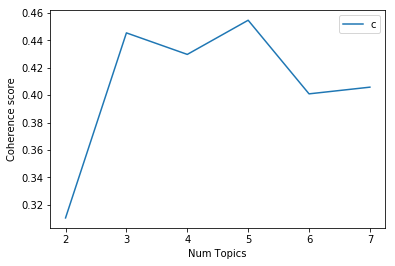

In [20]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Generate topic probability distribution for each review

In [47]:
for i in range(3):
    col_name = 'n_review_topic_'+str(i)
    data[col_name] = 0


In [48]:
for row_index, row in data.iterrows():
    row = row.copy()
    new_doc = n_dictionary.doc2bow(row['N_Review_clean'])
    lda_result = n_ldamallet[new_doc]
    for tpc in lda_result:
        col_name = 'n_review_topic_'+(str(tpc[0]).strip())
        print(row_index,col_name, tpc[1])
        data.loc[row_index,col_name] = tpc[1]

0 n_review_topic_0 0.3144654088050315
0 n_review_topic_1 0.35220125786163525
0 n_review_topic_2 0.33333333333333337
1 n_review_topic_0 0.26936026936026936
1 n_review_topic_1 0.25252525252525254
1 n_review_topic_2 0.4781144781144781
2 n_review_topic_0 0.33333333333333326
2 n_review_topic_1 0.3397435897435897
2 n_review_topic_2 0.32692307692307687
3 n_review_topic_0 0.36507936507936506
3 n_review_topic_1 0.31349206349206354
3 n_review_topic_2 0.32142857142857145
4 n_review_topic_0 0.30994152046783624
4 n_review_topic_1 0.3274853801169591
4 n_review_topic_2 0.36257309941520466
5 n_review_topic_0 0.3374485596707819
5 n_review_topic_1 0.3353909465020576
5 n_review_topic_2 0.3271604938271605
6 n_review_topic_0 0.34640522875816987
6 n_review_topic_1 0.326797385620915
6 n_review_topic_2 0.326797385620915
7 n_review_topic_0 0.38690476190476186
7 n_review_topic_1 0.2976190476190476
7 n_review_topic_2 0.3154761904761905
8 n_review_topic_0 0.33333333333333337
8 n_review_topic_1 0.3144654088050315


137 n_review_topic_1 0.358974358974359
137 n_review_topic_2 0.3205128205128205
138 n_review_topic_0 0.3296903460837887
138 n_review_topic_1 0.331511839708561
138 n_review_topic_2 0.33879781420765026
139 n_review_topic_0 0.34892787524366475
139 n_review_topic_1 0.34113060428849906
139 n_review_topic_2 0.30994152046783624
140 n_review_topic_0 0.36590038314176243
140 n_review_topic_1 0.30459770114942525
140 n_review_topic_2 0.32950191570881227
141 n_review_topic_0 0.37373737373737376
141 n_review_topic_1 0.3212121212121212
141 n_review_topic_2 0.305050505050505
142 n_review_topic_0 0.3502824858757062
142 n_review_topic_1 0.3333333333333333
142 n_review_topic_2 0.3163841807909604
143 n_review_topic_0 0.28120713305898487
143 n_review_topic_1 0.28120713305898487
143 n_review_topic_2 0.4375857338820303
144 n_review_topic_0 0.3347763347763348
144 n_review_topic_1 0.34632034632034636
144 n_review_topic_2 0.3189033189033189
145 n_review_topic_0 0.3205128205128205
145 n_review_topic_1 0.358974358

272 n_review_topic_1 0.35596707818930046
272 n_review_topic_2 0.30864197530864196
273 n_review_topic_0 0.3058419243986254
273 n_review_topic_1 0.3333333333333333
273 n_review_topic_2 0.3608247422680413
274 n_review_topic_0 0.36111111111111105
274 n_review_topic_1 0.36111111111111105
274 n_review_topic_2 0.2777777777777778
275 n_review_topic_0 0.328042328042328
275 n_review_topic_1 0.26631393298059963
275 n_review_topic_2 0.4056437389770723
276 n_review_topic_0 0.3144654088050315
276 n_review_topic_1 0.37106918238993714
276 n_review_topic_2 0.3144654088050315
277 n_review_topic_0 0.317948717948718
277 n_review_topic_1 0.317948717948718
277 n_review_topic_2 0.3641025641025641
278 n_review_topic_0 0.2996031746031746
278 n_review_topic_1 0.33333333333333337
278 n_review_topic_2 0.3670634920634921
279 n_review_topic_0 0.35220125786163525
279 n_review_topic_1 0.33333333333333337
279 n_review_topic_2 0.3144654088050315
280 n_review_topic_0 0.33333333333333337
280 n_review_topic_1 0.3333333333

407 n_review_topic_1 0.33333333333333337
407 n_review_topic_2 0.33333333333333337
408 n_review_topic_0 0.35323383084577115
408 n_review_topic_1 0.35323383084577115
408 n_review_topic_2 0.29353233830845776
409 n_review_topic_0 0.3314500941619586
409 n_review_topic_1 0.3860640301318267
409 n_review_topic_2 0.28248587570621475
410 n_review_topic_0 0.33974358974358976
410 n_review_topic_1 0.3205128205128205
410 n_review_topic_2 0.33974358974358976
411 n_review_topic_0 0.33974358974358976
411 n_review_topic_1 0.3205128205128205
411 n_review_topic_2 0.33974358974358976
412 n_review_topic_0 0.33974358974358976
412 n_review_topic_1 0.33974358974358976
412 n_review_topic_2 0.3205128205128205
413 n_review_topic_0 0.326797385620915
413 n_review_topic_1 0.34640522875816987
413 n_review_topic_2 0.326797385620915
414 n_review_topic_0 0.3274853801169591
414 n_review_topic_1 0.29239766081871343
414 n_review_topic_2 0.3801169590643274
415 n_review_topic_0 0.2843691148775894
415 n_review_topic_1 0.41619

475 n_review_topic_0 0.29861111111111105
475 n_review_topic_1 0.2805555555555555
475 n_review_topic_2 0.42083333333333345
476 n_review_topic_0 0.3333333333333333
476 n_review_topic_1 0.3817204301075269
476 n_review_topic_2 0.2849462365591398
477 n_review_topic_0 0.37777777777777777
477 n_review_topic_1 0.3452991452991453
477 n_review_topic_2 0.276923076923077
478 n_review_topic_0 0.35220125786163525
478 n_review_topic_1 0.3144654088050315
478 n_review_topic_2 0.33333333333333337
479 n_review_topic_0 0.3271604938271605
479 n_review_topic_1 0.3271604938271605
479 n_review_topic_2 0.345679012345679
480 n_review_topic_0 0.34567901234567905
480 n_review_topic_1 0.34567901234567905
480 n_review_topic_2 0.30864197530864196
481 n_review_topic_0 0.33333333333333337
481 n_review_topic_1 0.3144654088050315
481 n_review_topic_2 0.35220125786163525
482 n_review_topic_0 0.33333333333333337
482 n_review_topic_1 0.33333333333333337
482 n_review_topic_2 0.33333333333333337
483 n_review_topic_0 0.297619

542 n_review_topic_2 0.29353233830845776
543 n_review_topic_0 0.33333333333333337
543 n_review_topic_1 0.33333333333333337
543 n_review_topic_2 0.33333333333333337
544 n_review_topic_0 0.3385416666666667
544 n_review_topic_1 0.28472222222222227
544 n_review_topic_2 0.3767361111111111
545 n_review_topic_0 0.32380952380952377
545 n_review_topic_1 0.38095238095238093
545 n_review_topic_2 0.29523809523809524
546 n_review_topic_0 0.34920634920634924
546 n_review_topic_1 0.3068783068783069
546 n_review_topic_2 0.34391534391534395
547 n_review_topic_0 0.358974358974359
547 n_review_topic_1 0.3205128205128205
547 n_review_topic_2 0.3205128205128205
548 n_review_topic_0 0.36419753086419754
548 n_review_topic_1 0.30864197530864196
548 n_review_topic_2 0.3271604938271605
549 n_review_topic_0 0.33333333333333337
549 n_review_topic_1 0.33333333333333337
549 n_review_topic_2 0.33333333333333337
550 n_review_topic_0 0.3735632183908046
550 n_review_topic_1 0.339080459770115
550 n_review_topic_2 0.2873

677 n_review_topic_2 0.3205128205128205
678 n_review_topic_0 0.3467432950191571
678 n_review_topic_1 0.32183908045977017
678 n_review_topic_2 0.3314176245210728
679 n_review_topic_0 0.36458333333333326
679 n_review_topic_1 0.3072916666666667
679 n_review_topic_2 0.328125
680 n_review_topic_0 0.3393939393939394
680 n_review_topic_1 0.3575757575757576
680 n_review_topic_2 0.303030303030303
681 n_review_topic_0 0.36684303350970016
681 n_review_topic_1 0.3527336860670194
681 n_review_topic_2 0.28042328042328046
682 n_review_topic_0 0.2975517890772128
682 n_review_topic_1 0.3502824858757062
682 n_review_topic_2 0.352165725047081
683 n_review_topic_0 0.3205128205128205
683 n_review_topic_1 0.33974358974358976
683 n_review_topic_2 0.33974358974358976
684 n_review_topic_0 0.3393939393939394
684 n_review_topic_1 0.3575757575757576
684 n_review_topic_2 0.303030303030303
685 n_review_topic_0 0.3314176245210728
685 n_review_topic_1 0.3467432950191571
685 n_review_topic_2 0.32183908045977017
686 n_

812 n_review_topic_2 0.360655737704918
813 n_review_topic_0 0.326797385620915
813 n_review_topic_1 0.34640522875816987
813 n_review_topic_2 0.326797385620915
814 n_review_topic_0 0.33974358974358976
814 n_review_topic_1 0.3205128205128205
814 n_review_topic_2 0.33974358974358976
815 n_review_topic_0 0.3393939393939394
815 n_review_topic_1 0.3575757575757576
815 n_review_topic_2 0.303030303030303
816 n_review_topic_0 0.34567901234567905
816 n_review_topic_1 0.28395061728395066
816 n_review_topic_2 0.3703703703703704
817 n_review_topic_0 0.3212121212121212
817 n_review_topic_1 0.3393939393939394
817 n_review_topic_2 0.3393939393939394
818 n_review_topic_0 0.33333333333333337
818 n_review_topic_1 0.33333333333333337
818 n_review_topic_2 0.33333333333333337
819 n_review_topic_0 0.29444444444444445
819 n_review_topic_1 0.42777777777777776
819 n_review_topic_2 0.2777777777777778
820 n_review_topic_0 0.33333333333333337
820 n_review_topic_1 0.33333333333333337
820 n_review_topic_2 0.333333333

947 n_review_topic_1 0.326797385620915
947 n_review_topic_2 0.326797385620915
948 n_review_topic_0 0.34640522875816987
948 n_review_topic_1 0.326797385620915
948 n_review_topic_2 0.326797385620915
949 n_review_topic_0 0.29239766081871343
949 n_review_topic_1 0.3274853801169591
949 n_review_topic_2 0.3801169590643274
950 n_review_topic_0 0.3144654088050315
950 n_review_topic_1 0.33333333333333337
950 n_review_topic_2 0.35220125786163525
951 n_review_topic_0 0.34640522875816987
951 n_review_topic_1 0.326797385620915
951 n_review_topic_2 0.326797385620915
952 n_review_topic_0 0.35683760683760685
952 n_review_topic_1 0.32051282051282054
952 n_review_topic_2 0.3226495726495727
953 n_review_topic_0 0.358974358974359
953 n_review_topic_1 0.3205128205128205
953 n_review_topic_2 0.3205128205128205
954 n_review_topic_0 0.29629629629629634
954 n_review_topic_1 0.4232804232804233
954 n_review_topic_2 0.28042328042328046
955 n_review_topic_0 0.33879781420765026
955 n_review_topic_1 0.33879781420765

1080 n_review_topic_2 0.3041894353369763
1081 n_review_topic_0 0.3094017094017094
1081 n_review_topic_1 0.3213675213675214
1081 n_review_topic_2 0.3692307692307692
1082 n_review_topic_0 0.3154761904761905
1082 n_review_topic_1 0.3253968253968254
1082 n_review_topic_2 0.35912698412698413
1083 n_review_topic_0 0.35220125786163525
1083 n_review_topic_1 0.3144654088050315
1083 n_review_topic_2 0.33333333333333337
1084 n_review_topic_0 0.2935323383084577
1084 n_review_topic_1 0.30845771144278605
1084 n_review_topic_2 0.3980099502487562
1085 n_review_topic_0 0.35429769392033544
1085 n_review_topic_1 0.3312368972746332
1085 n_review_topic_2 0.3144654088050315
1086 n_review_topic_0 0.3597883597883597
1086 n_review_topic_1 0.3580246913580246
1086 n_review_topic_2 0.2821869488536155
1087 n_review_topic_0 0.3682539682539683
1087 n_review_topic_1 0.2571428571428572
1087 n_review_topic_2 0.3746031746031746
1088 n_review_topic_0 0.2843691148775895
1088 n_review_topic_1 0.4124293785310734
1088 n_revi

1212 n_review_topic_1 0.37448559670781895
1212 n_review_topic_2 0.30864197530864196
1213 n_review_topic_0 0.33333333333333337
1213 n_review_topic_1 0.33333333333333337
1213 n_review_topic_2 0.33333333333333337
1214 n_review_topic_0 0.33164983164983164
1214 n_review_topic_1 0.31818181818181823
1214 n_review_topic_2 0.3501683501683502
1215 n_review_topic_0 0.3597883597883597
1215 n_review_topic_1 0.32275132275132273
1215 n_review_topic_2 0.31746031746031744
1216 n_review_topic_0 0.3459119496855346
1216 n_review_topic_1 0.339622641509434
1216 n_review_topic_2 0.3144654088050315
1217 n_review_topic_0 0.326797385620915
1217 n_review_topic_1 0.34640522875816987
1217 n_review_topic_2 0.326797385620915
1218 n_review_topic_0 0.3333333333333333
1218 n_review_topic_1 0.31250000000000006
1218 n_review_topic_2 0.3541666666666667
1219 n_review_topic_0 0.27566807313642755
1219 n_review_topic_1 0.3938115330520394
1219 n_review_topic_2 0.3305203938115331
1220 n_review_topic_0 0.33333333333333337
1220 n

1344 n_review_topic_0 0.35416666666666663
1344 n_review_topic_1 0.35416666666666663
1344 n_review_topic_2 0.2916666666666667
1345 n_review_topic_0 0.3224043715846994
1345 n_review_topic_1 0.3715846994535518
1345 n_review_topic_2 0.30601092896174864
1346 n_review_topic_0 0.3172043010752688
1346 n_review_topic_1 0.3978494623655914
1346 n_review_topic_2 0.2849462365591398
1347 n_review_topic_0 0.27777777777777773
1347 n_review_topic_1 0.4688346883468836
1347 n_review_topic_2 0.25338753387533874
1348 n_review_topic_0 0.3045977011494253
1348 n_review_topic_1 0.40804597701149425
1348 n_review_topic_2 0.2873563218390805
1349 n_review_topic_0 0.2896174863387978
1349 n_review_topic_1 0.42076502732240434
1349 n_review_topic_2 0.2896174863387978
1350 n_review_topic_0 0.3205128205128205
1350 n_review_topic_1 0.33974358974358976
1350 n_review_topic_2 0.33974358974358976
1351 n_review_topic_0 0.3697318007662835
1351 n_review_topic_1 0.339080459770115
1351 n_review_topic_2 0.2911877394636015
1352 n_r

1476 n_review_topic_0 0.32183908045977017
1476 n_review_topic_1 0.32183908045977017
1476 n_review_topic_2 0.3563218390804598
1477 n_review_topic_0 0.3563218390804598
1477 n_review_topic_1 0.3563218390804598
1477 n_review_topic_2 0.28735632183908044
1478 n_review_topic_0 0.345679012345679
1478 n_review_topic_1 0.3271604938271605
1478 n_review_topic_2 0.3271604938271605
1479 n_review_topic_0 0.32716049382716056
1479 n_review_topic_1 0.3641975308641976
1479 n_review_topic_2 0.30864197530864196
1480 n_review_topic_0 0.32679738562091504
1480 n_review_topic_1 0.32679738562091504
1480 n_review_topic_2 0.3464052287581699
1481 n_review_topic_0 0.33974358974358976
1481 n_review_topic_1 0.3205128205128205
1481 n_review_topic_2 0.33974358974358976
1482 n_review_topic_0 0.3817204301075269
1482 n_review_topic_1 0.3333333333333333
1482 n_review_topic_2 0.2849462365591398
1483 n_review_topic_0 0.33333333333333337
1483 n_review_topic_1 0.33333333333333337
1483 n_review_topic_2 0.33333333333333337
1484 

1608 n_review_topic_0 0.34892787524366475
1608 n_review_topic_1 0.34113060428849906
1608 n_review_topic_2 0.30994152046783624
1609 n_review_topic_0 0.33333333333333337
1609 n_review_topic_1 0.33333333333333337
1609 n_review_topic_2 0.33333333333333337
1610 n_review_topic_0 0.2745098039215687
1610 n_review_topic_1 0.3709150326797386
1610 n_review_topic_2 0.3545751633986928
1611 n_review_topic_0 0.33333333333333337
1611 n_review_topic_1 0.33333333333333337
1611 n_review_topic_2 0.33333333333333337
1612 n_review_topic_0 0.34567901234567905
1612 n_review_topic_1 0.34567901234567905
1612 n_review_topic_2 0.30864197530864196
1613 n_review_topic_0 0.3212121212121212
1613 n_review_topic_1 0.3393939393939394
1613 n_review_topic_2 0.3393939393939394
1614 n_review_topic_0 0.34640522875816987
1614 n_review_topic_1 0.326797385620915
1614 n_review_topic_2 0.326797385620915
1615 n_review_topic_0 0.3111111111111111
1615 n_review_topic_1 0.37777777777777777
1615 n_review_topic_2 0.3111111111111111
1616

1739 n_review_topic_2 0.326797385620915
1740 n_review_topic_0 0.3575757575757576
1740 n_review_topic_1 0.303030303030303
1740 n_review_topic_2 0.3393939393939394
1741 n_review_topic_0 0.3351548269581056
1741 n_review_topic_1 0.35519125683060104
1741 n_review_topic_2 0.30965391621129323
1742 n_review_topic_0 0.34640522875816987
1742 n_review_topic_1 0.326797385620915
1742 n_review_topic_2 0.326797385620915
1743 n_review_topic_0 0.358974358974359
1743 n_review_topic_1 0.3205128205128205
1743 n_review_topic_2 0.3205128205128205
1744 n_review_topic_0 0.33333333333333337
1744 n_review_topic_1 0.33333333333333337
1744 n_review_topic_2 0.33333333333333337
1745 n_review_topic_0 0.3572649572649572
1745 n_review_topic_1 0.34188034188034183
1745 n_review_topic_2 0.30085470085470084
1746 n_review_topic_0 0.3502824858757062
1746 n_review_topic_1 0.3163841807909605
1746 n_review_topic_2 0.33333333333333337
1747 n_review_topic_0 0.33333333333333337
1747 n_review_topic_1 0.33333333333333337
1747 n_rev

1871 n_review_topic_1 0.33333333333333337
1871 n_review_topic_2 0.3417190775681342
1872 n_review_topic_0 0.339080459770115
1872 n_review_topic_1 0.3735632183908046
1872 n_review_topic_2 0.2873563218390805
1873 n_review_topic_0 0.33333333333333337
1873 n_review_topic_1 0.33333333333333337
1873 n_review_topic_2 0.33333333333333337
1874 n_review_topic_0 0.32716049382716056
1874 n_review_topic_1 0.3641975308641976
1874 n_review_topic_2 0.30864197530864196
1875 n_review_topic_0 0.30864197530864196
1875 n_review_topic_1 0.3827160493827161
1875 n_review_topic_2 0.30864197530864196
1876 n_review_topic_0 0.34946236559139776
1876 n_review_topic_1 0.3172043010752688
1876 n_review_topic_2 0.3333333333333333
1877 n_review_topic_0 0.34567901234567905
1877 n_review_topic_1 0.34567901234567905
1877 n_review_topic_2 0.30864197530864196
1878 n_review_topic_0 0.33333333333333337
1878 n_review_topic_1 0.35220125786163525
1878 n_review_topic_2 0.3144654088050315
1879 n_review_topic_0 0.3718518518518519
187

2003 n_review_topic_0 0.2760416666666667
2003 n_review_topic_1 0.2916666666666667
2003 n_review_topic_2 0.43229166666666663
2004 n_review_topic_0 0.3562610229276895
2004 n_review_topic_1 0.2962962962962963
2004 n_review_topic_2 0.34744268077601403
2005 n_review_topic_0 0.33974358974358976
2005 n_review_topic_1 0.3205128205128205
2005 n_review_topic_2 0.33974358974358976
2006 n_review_topic_0 0.34640522875816987
2006 n_review_topic_1 0.326797385620915
2006 n_review_topic_2 0.326797385620915
2007 n_review_topic_0 0.33333333333333337
2007 n_review_topic_1 0.33333333333333337
2007 n_review_topic_2 0.33333333333333337
2008 n_review_topic_0 0.34640522875816987
2008 n_review_topic_1 0.326797385620915
2008 n_review_topic_2 0.326797385620915
2009 n_review_topic_0 0.35220125786163525
2009 n_review_topic_1 0.33333333333333337
2009 n_review_topic_2 0.3144654088050315
2010 n_review_topic_0 0.3212121212121212
2010 n_review_topic_1 0.3757575757575758
2010 n_review_topic_2 0.30303030303030304
2011 n_r

2069 n_review_topic_0 0.339080459770115
2069 n_review_topic_1 0.3563218390804598
2069 n_review_topic_2 0.30459770114942525
2070 n_review_topic_0 0.33974358974358976
2070 n_review_topic_1 0.3205128205128205
2070 n_review_topic_2 0.33974358974358976
2071 n_review_topic_0 0.34444444444444444
2071 n_review_topic_1 0.37777777777777777
2071 n_review_topic_2 0.2777777777777778
2072 n_review_topic_0 0.3511904761904762
2072 n_review_topic_1 0.3154761904761905
2072 n_review_topic_2 0.33333333333333337
2073 n_review_topic_0 0.38011695906432746
2073 n_review_topic_1 0.2923976608187135
2073 n_review_topic_2 0.3274853801169591
2074 n_review_topic_0 0.33974358974358976
2074 n_review_topic_1 0.33974358974358976
2074 n_review_topic_2 0.3205128205128205
2075 n_review_topic_0 0.27843137254901956
2075 n_review_topic_1 0.24705882352941175
2075 n_review_topic_2 0.4745098039215687
2076 n_review_topic_0 0.3801169590643274
2076 n_review_topic_1 0.30994152046783624
2076 n_review_topic_2 0.30994152046783624
2077

2200 n_review_topic_1 0.3783783783783784
2200 n_review_topic_2 0.3153153153153153
2201 n_review_topic_0 0.3540489642184558
2201 n_review_topic_1 0.36346516007532953
2201 n_review_topic_2 0.28248587570621475
2202 n_review_topic_0 0.3189300411522634
2202 n_review_topic_1 0.34567901234567905
2202 n_review_topic_2 0.33539094650205764
2203 n_review_topic_0 0.33333333333333337
2203 n_review_topic_1 0.33333333333333337
2203 n_review_topic_2 0.33333333333333337
2204 n_review_topic_0 0.33333333333333337
2204 n_review_topic_1 0.33333333333333337
2204 n_review_topic_2 0.33333333333333337
2205 n_review_topic_0 0.34640522875816987
2205 n_review_topic_1 0.326797385620915
2205 n_review_topic_2 0.326797385620915
2206 n_review_topic_0 0.26688453159041386
2206 n_review_topic_1 0.43464052287581706
2206 n_review_topic_2 0.298474945533769
2207 n_review_topic_0 0.358974358974359
2207 n_review_topic_1 0.3205128205128205
2207 n_review_topic_2 0.3205128205128205
2208 n_review_topic_0 0.37575757575757573
2208 n

2332 n_review_topic_0 0.3393939393939394
2332 n_review_topic_1 0.3212121212121212
2332 n_review_topic_2 0.3393939393939394
2333 n_review_topic_0 0.33333333333333337
2333 n_review_topic_1 0.33333333333333337
2333 n_review_topic_2 0.33333333333333337
2334 n_review_topic_0 0.2728758169934641
2334 n_review_topic_1 0.34477124183006536
2334 n_review_topic_2 0.3823529411764706
2335 n_review_topic_0 0.3274853801169591
2335 n_review_topic_1 0.31384015594541914
2335 n_review_topic_2 0.3586744639376218
2336 n_review_topic_0 0.32905982905982906
2336 n_review_topic_1 0.3504273504273504
2336 n_review_topic_2 0.3205128205128205
2337 n_review_topic_0 0.345679012345679
2337 n_review_topic_1 0.3271604938271605
2337 n_review_topic_2 0.3271604938271605
2338 n_review_topic_0 0.3976608187134502
2338 n_review_topic_1 0.29239766081871343
2338 n_review_topic_2 0.30994152046783624
2339 n_review_topic_0 0.3156028368794325
2339 n_review_topic_1 0.2742316784869976
2339 n_review_topic_2 0.41016548463356983
2340 n_r

2463 n_review_topic_2 0.3450292397660819
2464 n_review_topic_0 0.3205128205128205
2464 n_review_topic_1 0.33974358974358976
2464 n_review_topic_2 0.33974358974358976
2465 n_review_topic_0 0.33333333333333337
2465 n_review_topic_1 0.33333333333333337
2465 n_review_topic_2 0.33333333333333337
2466 n_review_topic_0 0.3274853801169591
2466 n_review_topic_1 0.3801169590643274
2466 n_review_topic_2 0.29239766081871343
2467 n_review_topic_0 0.3641975308641976
2467 n_review_topic_1 0.32716049382716056
2467 n_review_topic_2 0.30864197530864196
2468 n_review_topic_0 0.20964360587002093
2468 n_review_topic_1 0.24318658280922426
2468 n_review_topic_2 0.5471698113207548
2469 n_review_topic_0 0.34444444444444444
2469 n_review_topic_1 0.3277777777777778
2469 n_review_topic_2 0.3277777777777778
2470 n_review_topic_0 0.326797385620915
2470 n_review_topic_1 0.34640522875816987
2470 n_review_topic_2 0.326797385620915
2471 n_review_topic_0 0.33333333333333337
2471 n_review_topic_1 0.33333333333333337
2471

2595 n_review_topic_0 0.39444444444444443
2595 n_review_topic_1 0.3277777777777778
2595 n_review_topic_2 0.2777777777777778
2596 n_review_topic_0 0.33333333333333337
2596 n_review_topic_1 0.33333333333333337
2596 n_review_topic_2 0.33333333333333337
2597 n_review_topic_0 0.35220125786163525
2597 n_review_topic_1 0.3144654088050315
2597 n_review_topic_2 0.33333333333333337
2598 n_review_topic_0 0.3075396825396825
2598 n_review_topic_1 0.36904761904761907
2598 n_review_topic_2 0.32341269841269843
2599 n_review_topic_0 0.33602150537634407
2599 n_review_topic_1 0.24014336917562717
2599 n_review_topic_2 0.4238351254480287
2600 n_review_topic_0 0.3245149911816579
2600 n_review_topic_1 0.345679012345679
2600 n_review_topic_2 0.3298059964726632
2601 n_review_topic_0 0.3511904761904762
2601 n_review_topic_1 0.3253968253968254
2601 n_review_topic_2 0.32341269841269843
2602 n_review_topic_0 0.33333333333333337
2602 n_review_topic_1 0.33333333333333337
2602 n_review_topic_2 0.33333333333333337
260

2726 n_review_topic_2 0.3131313131313132
2727 n_review_topic_0 0.34640522875816987
2727 n_review_topic_1 0.326797385620915
2727 n_review_topic_2 0.326797385620915
2728 n_review_topic_0 0.33333333333333337
2728 n_review_topic_1 0.33333333333333337
2728 n_review_topic_2 0.33333333333333337
2729 n_review_topic_0 0.33333333333333337
2729 n_review_topic_1 0.33333333333333337
2729 n_review_topic_2 0.33333333333333337
2730 n_review_topic_0 0.33333333333333337
2730 n_review_topic_1 0.33333333333333337
2730 n_review_topic_2 0.33333333333333337
2731 n_review_topic_0 0.30303030303030304
2731 n_review_topic_1 0.3939393939393939
2731 n_review_topic_2 0.30303030303030304
2732 n_review_topic_0 0.34640522875816987
2732 n_review_topic_1 0.326797385620915
2732 n_review_topic_2 0.326797385620915
2733 n_review_topic_0 0.34567901234567905
2733 n_review_topic_1 0.34567901234567905
2733 n_review_topic_2 0.30864197530864196
2734 n_review_topic_0 0.3144654088050315
2734 n_review_topic_1 0.3584905660377359
2734

2858 n_review_topic_1 0.33333333333333337
2858 n_review_topic_2 0.33333333333333337
2859 n_review_topic_0 0.35220125786163525
2859 n_review_topic_1 0.33333333333333337
2859 n_review_topic_2 0.3144654088050315
2860 n_review_topic_0 0.31189083820662766
2860 n_review_topic_1 0.3957115009746588
2860 n_review_topic_2 0.29239766081871343
2861 n_review_topic_0 0.33333333333333337
2861 n_review_topic_1 0.33333333333333337
2861 n_review_topic_2 0.33333333333333337
2862 n_review_topic_0 0.34640522875816987
2862 n_review_topic_1 0.326797385620915
2862 n_review_topic_2 0.326797385620915
2863 n_review_topic_0 0.34920634920634924
2863 n_review_topic_1 0.3253968253968254
2863 n_review_topic_2 0.3253968253968254
2864 n_review_topic_0 0.3888888888888889
2864 n_review_topic_1 0.3225806451612903
2864 n_review_topic_2 0.2885304659498208
2865 n_review_topic_0 0.31069958847736623
2865 n_review_topic_1 0.32716049382716045
2865 n_review_topic_2 0.36213991769547316
2866 n_review_topic_0 0.3511904761904762
2866

2990 n_review_topic_1 0.33333333333333326
2990 n_review_topic_2 0.2684144818976279
2991 n_review_topic_0 0.31826741996233526
2991 n_review_topic_1 0.3314500941619586
2991 n_review_topic_2 0.3502824858757062
2992 n_review_topic_0 0.3905228758169934
2992 n_review_topic_1 0.27450980392156865
2992 n_review_topic_2 0.3349673202614379
2993 n_review_topic_0 0.38011695906432746
2993 n_review_topic_1 0.2923976608187135
2993 n_review_topic_2 0.3274853801169591
2994 n_review_topic_0 0.3450292397660819
2994 n_review_topic_1 0.30994152046783624
2994 n_review_topic_2 0.3450292397660819
2995 n_review_topic_0 0.36507936507936506
2995 n_review_topic_1 0.2976190476190476
2995 n_review_topic_2 0.3373015873015873
2996 n_review_topic_0 0.22623828647925032
2996 n_review_topic_1 0.2570281124497991
2996 n_review_topic_2 0.5167336010709506
2997 n_review_topic_0 0.326797385620915
2997 n_review_topic_1 0.34640522875816987
2997 n_review_topic_2 0.326797385620915
2998 n_review_topic_0 0.34640522875816987
2998 n_re

3121 n_review_topic_2 0.3277777777777778
3122 n_review_topic_0 0.36931216931216937
3122 n_review_topic_1 0.37248677248677253
3122 n_review_topic_2 0.2582010582010581
3123 n_review_topic_0 0.3450292397660819
3123 n_review_topic_1 0.36257309941520466
3123 n_review_topic_2 0.29239766081871343
3124 n_review_topic_0 0.33333333333333337
3124 n_review_topic_1 0.35220125786163525
3124 n_review_topic_2 0.3144654088050315
3125 n_review_topic_0 0.3664717348927875
3125 n_review_topic_1 0.32163742690058483
3125 n_review_topic_2 0.31189083820662766
3126 n_review_topic_0 0.3661971830985915
3126 n_review_topic_1 0.3708920187793427
3126 n_review_topic_2 0.26291079812206575
3127 n_review_topic_0 0.27860696517412936
3127 n_review_topic_1 0.4112769485903814
3127 n_review_topic_2 0.3101160862354892
3128 n_review_topic_0 0.26422764227642276
3128 n_review_topic_1 0.3495934959349594
3128 n_review_topic_2 0.3861788617886179
3129 n_review_topic_0 0.273224043715847
3129 n_review_topic_1 0.45355191256830596
3129 

3253 n_review_topic_0 0.3205128205128205
3253 n_review_topic_1 0.358974358974359
3253 n_review_topic_2 0.3205128205128205
3254 n_review_topic_0 0.3205128205128205
3254 n_review_topic_1 0.358974358974359
3254 n_review_topic_2 0.3205128205128205
3255 n_review_topic_0 0.34920634920634924
3255 n_review_topic_1 0.3174603174603175
3255 n_review_topic_2 0.33333333333333337
3256 n_review_topic_0 0.33974358974358976
3256 n_review_topic_1 0.33974358974358976
3256 n_review_topic_2 0.3205128205128205
3257 n_review_topic_0 0.326797385620915
3257 n_review_topic_1 0.34640522875816987
3257 n_review_topic_2 0.326797385620915
3258 n_review_topic_0 0.35220125786163525
3258 n_review_topic_1 0.33333333333333337
3258 n_review_topic_2 0.3144654088050315
3259 n_review_topic_0 0.303030303030303
3259 n_review_topic_1 0.37575757575757573
3259 n_review_topic_2 0.3212121212121212
3260 n_review_topic_0 0.3172043010752688
3260 n_review_topic_1 0.34408602150537626
3260 n_review_topic_2 0.3387096774193548
3261 n_revie

3384 n_review_topic_1 0.3511904761904762
3384 n_review_topic_2 0.2976190476190476
3385 n_review_topic_0 0.3563218390804598
3385 n_review_topic_1 0.339080459770115
3385 n_review_topic_2 0.30459770114942525
3386 n_review_topic_0 0.3212121212121212
3386 n_review_topic_1 0.3757575757575758
3386 n_review_topic_2 0.30303030303030304
3387 n_review_topic_0 0.3511904761904762
3387 n_review_topic_1 0.3154761904761905
3387 n_review_topic_2 0.33333333333333337
3388 n_review_topic_0 0.3563218390804598
3388 n_review_topic_1 0.32183908045977017
3388 n_review_topic_2 0.32183908045977017
3389 n_review_topic_0 0.3801169590643274
3389 n_review_topic_1 0.3274853801169591
3389 n_review_topic_2 0.29239766081871343
3390 n_review_topic_0 0.37106918238993714
3390 n_review_topic_1 0.3144654088050315
3390 n_review_topic_2 0.3144654088050315
3391 n_review_topic_0 0.345679012345679
3391 n_review_topic_1 0.3271604938271605
3391 n_review_topic_2 0.3271604938271605
3392 n_review_topic_0 0.35119047619047616
3392 n_rev

3516 n_review_topic_0 0.3111111111111111
3516 n_review_topic_1 0.34629629629629627
3516 n_review_topic_2 0.34259259259259256
3517 n_review_topic_0 0.33333333333333337
3517 n_review_topic_1 0.36904761904761907
3517 n_review_topic_2 0.2976190476190476
3518 n_review_topic_0 0.33333333333333337
3518 n_review_topic_1 0.33333333333333337
3518 n_review_topic_2 0.33333333333333337
3519 n_review_topic_0 0.32183908045977017
3519 n_review_topic_1 0.3908045977011494
3519 n_review_topic_2 0.28735632183908044


In [49]:
#data = data.drop("review_topic_4", axis=1)
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,...,N_Review_lower,N_Review_tokenize,N_Review_word,N_Review_nostop,N_Review_lemmatize,N_Review_stem,N_Review_clean,n_review_topic_0,n_review_topic_1,n_review_topic_2
0,626 Chiswick High St Chiswick London W4 5RY Un...,562,7/14/2016,8.5,Clayton Hotel Chiswick,United Kingdom,couldn t get the air con to shut off kept tur...,16,1944,big room and bathroom was given quieter rear ...,...,couldn t get the air con to shut off kept tur...,"[couldn, t, get, the, air, con, to, shut, off,...","[couldn, t, get, the, air, con, to, shut, off,...","[get, air, con, shut, kept, turning, back]","[get, air, con, shut, kept, turning, back]","[get, air, con, shut, kept, turn, back]","[shut, kept, turn, back]",0.314465,0.352201,0.333333
1,78 84 Sussex Gardens Westminster Borough Londo...,636,7/12/2016,7.7,Shaftesbury Metropolis London Hyde Park,United Kingdom,the wait for our room to be ready we arrived ...,58,2867,the location to hyde park and paddington were...,...,the wait for our room to be ready we arrived ...,"[the, wait, for, our, room, to, be, ready, we,...","[the, wait, for, our, room, to, be, ready, we,...","[wait, ready, arrived, expected, freshen, wait...","[wait, ready, arrived, expected, freshen, wait...","[wait, readi, arriv, expect, freshen, wait, ne...","[wait, readi, arriv, expect, freshen, wait, ne...",0.269360,0.252525,0.478114
2,24 Ludgate Hill City of London London EC4M 7DR...,918,6/3/2017,8.4,Club Quarters Hotel St Paul s,United Kingdom,the aircon was a little temperamental,8,4117,location is wonderful price is excellent for ...,...,the aircon was a little temperamental,"[the, aircon, was, a, little, temperamental]","[the, aircon, was, a, little, temperamental]","[aircon, temperamental]","[aircon, temperamental]","[aircon, temperament]","[aircon, temperament]",0.333333,0.339744,0.326923
3,Stratton Street Mayfair Westminster Borough Lo...,581,2/21/2016,8.4,The May Fair Hotel,United Kingdom,bedroom could have been better there was a te...,23,1994,the bathroom was my favourite and the mayfair...,...,bedroom could have been better there was a te...,"[bedroom, could, have, been, better, there, wa...","[bedroom, could, have, been, better, there, wa...","[bedroom, better, tear, fabric, bed, needs, up...","[bedroom, better, tear, fabric, bed, need, upd...","[bedroom, better, tear, fabric, bed, need, upd...","[bedroom, better, tear, fabric, need, updat, o...",0.365079,0.313492,0.321429
4,52 54 Upper Richmond Road Wandsworth London SW...,144,8/11/2015,8.2,The Lodge Hotel Putney,United Kingdom,everything from start to finish noisy hotel b...,18,525,nothing worst hotel i have stayed in,...,everything from start to finish noisy hotel b...,"[everything, from, start, to, finish, noisy, h...","[everything, from, start, to, finish, noisy, h...","[start, finish, noisy, booking, right, rude, s...","[start, finish, noisy, booking, right, rude, s...","[start, finish, noisi, book, right, rude, staf...","[start, finish, noisi, book, right, rude, staf...",0.309942,0.327485,0.362573


In [50]:
data.to_csv(r'C:\Users\lohro\Desktop\TEXT ANALYTICS\Project\Code\Test3000_negative.csv', index = False)